##Importing all csv files using a MultiIndex structure

Samplingpoint -> Pollutant -> StartTime

Rows containing Bulk in the Samplingpoint name are dropped, because they are only monthly

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
import math
import os
import glob
%matplotlib inline

package_dir = os.getcwd()

print(package_dir)

df = pd.DataFrame()

print('Loading CSVs\n')
for file in glob.glob('res/*.csv'):
    read = pd.read_csv(file,
                 encoding="utf-16", parse_dates=[13, 14],
                 infer_datetime_format=True,
                 index_col=[4, 8, 13])
    df = pd.concat([df, read])
print('\nFinished Loading')
print('Sorting')
df = df.sort_index()
print('Finished sorting')

/home/sebastian/Programming/Bachelorthesis
Loading CSVs




Finished Loading
Sorting


Finished sorting


In [2]:
print(df.dtypes)
print(df.head())

Countrycode                  object
Namespace                    object
AirQualityNetwork            object
AirQualityStation            object
SamplingPoint                object
SamplingProcess              object
Sample                       object
AirPollutantCode             object
AveragingTime                object
Concentration               float64
UnitOfMeasurement            object
DatetimeEnd          datetime64[ns]
Validity                      int64
Verification                  int64
dtype: object
                                                          Countrycode  \
AirQualityStationEoICode AirPollutant DatetimeBegin                     
DESN025                  As in PM10   2012-12-31 23:00:00          DE   
                                      2013-01-06 23:00:00          DE   
                                      2013-01-12 23:00:00          DE   
                                      2013-01-18 23:00:00          DE   
                                      2013-0

Multiindex can be navigated using the loc method.

Row selection is done via the [] operator using counting slices or datetime parsed from strings

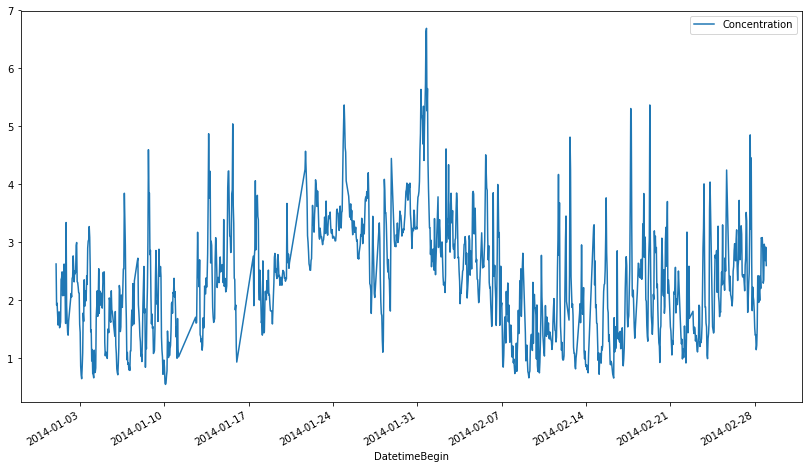

In [3]:
df.loc['DESN025', 'C6H6']['2014-01':'2014-02'].plot(y='Concentration', figsize=(14,8))

In [4]:
for eoi, new_df in df.groupby(level=0):
    print(new_df.groupby(['AirPollutant']).count()['AirPollutantCode'], '\n')

AirPollutant
As in PM10                         243
BaP in PM10                        485
Benzo(a)anthracene in PM10         485
Benzo(b)fluoranthene in PM10       485
Benzo(j)fluoranthene in PM10       485
Benzo(k)fluoranthene in PM10       485
C6H5-CH3                         31400
C6H6                             41804
Cd                                  48
Cd in PM10                         243
Dibenzo(ah)anthracene in PM10      485
EC in PM10                         182
Indeno-(1,2,3-cd)pyrene in PM      485
NO                               46093
NO2                              37399
NOX as NO2                       44090
Ni in PM10                         233
OC in PM10                         182
PM10                             47831
PM2.5                             1829
Pb                                  48
Pb in PM10                         243
SO2                              45799
Name: AirPollutantCode, dtype: int64 



AirPollutant
Cd               47
EC in PM10      181
NO            46210
NO2           37495
NOX as NO2    44242
O3            46161
OC in PM10      181
PM10          47594
PM2.5          1830
Pb               47
Name: AirPollutantCode, dtype: int64 



AirPollutant
As in PM10                         243
BaP in PM10                        483
Benzo(a)anthracene in PM10         483
Benzo(b)fluoranthene in PM10       483
Benzo(j)fluoranthene in PM10       483
Benzo(k)fluoranthene in PM10       483
Cd in PM10                         243
Dibenzo(ah)anthracene in PM10      483
EC in PM10                         182
Indeno-(1,2,3-cd)pyrene in PM      483
NO                               46242
NO2                              37500
NOX as NO2                       44189
Ni in PM10                         233
OC in PM10                         182
PM10                             47473
Name: AirPollutantCode, dtype: int64 

AirPollutant
O3    46318
Name: AirPollutantCode, dtype: int64 



In [5]:
ds = pd.to_datetime(df.loc['DESN025', 'PM10'].index.values)
y = df.loc['DESN025', 'PM10', :]['Concentration'].values

print(ds)
print(y, '\n')

df2 = pd.DataFrame(data={'ds':ds, 'y':y})

print(df2.head())
print(df2.dtypes)

#print(df.loc['DESN025'].groupby(['AirPollutant']).count()['AirPollutantCode'])

DatetimeIndex(['2012-12-31 23:00:00', '2012-12-31 23:00:00',
               '2013-01-01 00:00:00', '2013-01-01 01:00:00',
               '2013-01-01 02:00:00', '2013-01-01 03:00:00',
               '2013-01-01 04:00:00', '2013-01-01 05:00:00',
               '2013-01-01 06:00:00', '2013-01-01 07:00:00',
               ...
               '2018-04-27 04:00:00', '2018-04-27 05:00:00',
               '2018-04-27 06:00:00', '2018-04-27 07:00:00',
               '2018-04-27 08:00:00', '2018-04-27 09:00:00',
               '2018-04-27 10:00:00', '2018-04-27 11:00:00',
               '2018-04-27 12:00:00', '2018-04-27 13:00:00'],
              dtype='datetime64[ns]', length=47831, freq=None)
[200.165  34.72  205.237 ...  14.69   17.26   13.37 ] 

                   ds        y
0 2012-12-31 23:00:00  200.165
1 2012-12-31 23:00:00   34.720
2 2013-01-01 00:00:00  205.237
3 2013-01-01 01:00:00   61.588
4 2013-01-01 02:00:00   27.727
ds    datetime64[ns]
y            float64
dtype: object


ds    47831
y     47831
dtype: int64


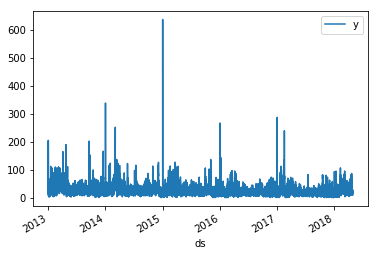

In [6]:
df2.plot(x='ds', y='y')
print(df2.count())

In [7]:
np.seterr(divide='ignore')
df2['y'] = pd.DataFrame(np.log(df2['y'])).replace([np.inf, -np.inf], 0)
np.seterr(divide='warn')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

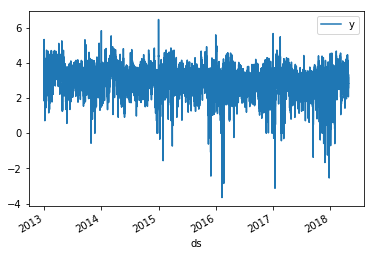

In [8]:
df2.plot(x='ds', y='y')

In [9]:
df2_train = df2[:40000]
df2_test = df2[40000:40240]

In [10]:
model = Prophet()

In [11]:
model.fit(df2_train)
future = model.make_future_dataframe(periods=240, freq='H')

/usr/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [12]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



,ds,yhat,yhat_lower,yhat_upper
40235,2017-06-18 05:00:00,2.529229,1.788295,3.244847
40236,2017-06-18 06:00:00,2.595406,1.856124,3.314239
40237,2017-06-18 07:00:00,2.618038,1.895119,3.380650
40238,2017-06-18 08:00:00,2.602393,1.887841,3.325153
40239,2017-06-18 09:00:00,2.571947,1.814288,3.321914


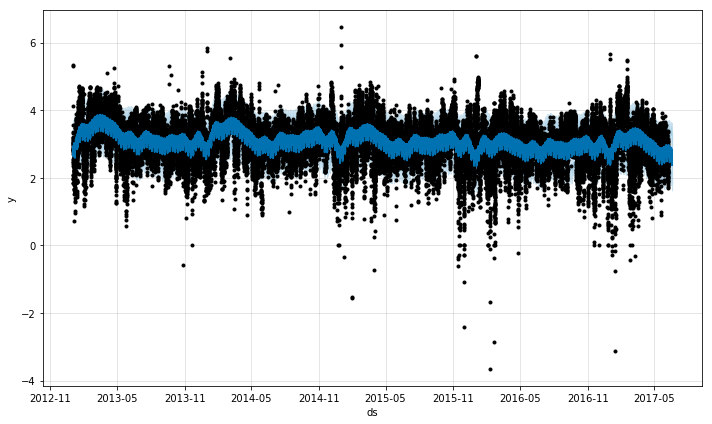

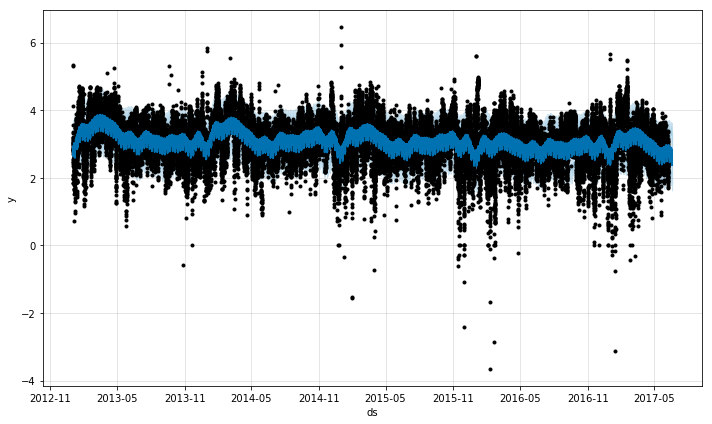

In [13]:
model.plot(forecast)


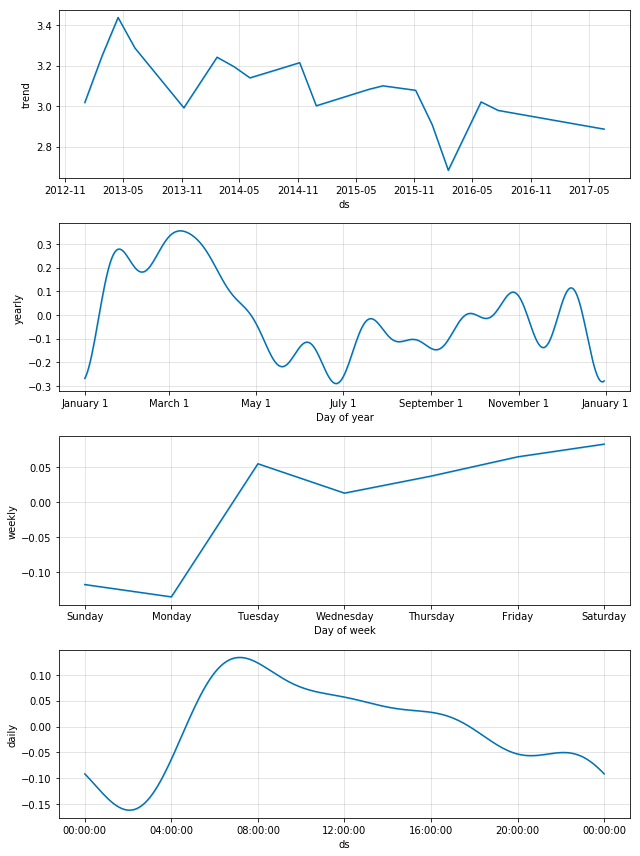

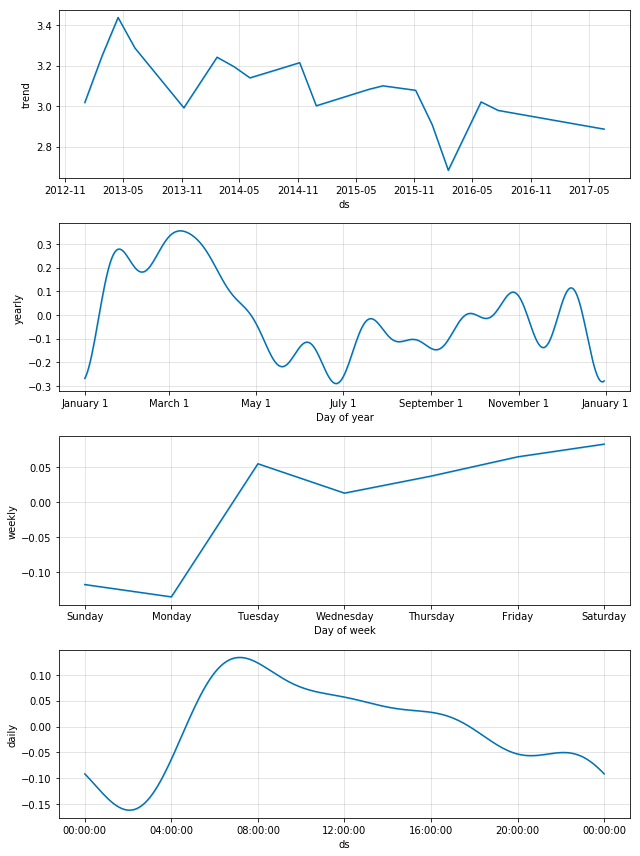

In [14]:
model.plot_components(forecast)

In [15]:
# retransform using e
y_hat = np.exp(forecast['yhat'][20000:])
y_true = np.exp(df2_test['y'])
 
# compute the mean square error
mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 24.79 MSE (4.98 RMSE)


In [16]:
print(y_hat)

20000    33.812479
20001    32.873065
20002    32.105310
20003    31.657474
20004    31.317419
20005    30.916724
20006    30.515874
20007    30.235381
20008    30.006579
20009    29.580523
20010    28.820649
20011    27.936034
20012    27.327407
20013    27.187024
20014    27.251866
20015    26.967463
20016    26.967463
20017    26.037106
20018    24.841072
20019    24.194368
20020    24.754582
20021    26.630880
20022    29.231437
20023    31.439061
20024    32.357146
20025    32.034266
20026    31.230336
20027    30.602344
20028    30.290567
20029    30.091954
           ...    
40210    14.530519
40211    15.862137
40212    16.951620
40213    17.320664
40214    17.009711
40215    16.436084
40216    15.951000
40217    15.626009
40218    15.354004
40219    15.051983
40220    14.749973
40221    14.506047
40222    14.286516
40223    13.973571
40224    13.505868
40225    12.984900
40226    12.597375
40227    12.428558
40228    12.354392
40229    12.123854
40230    11.609155
40231    10.

In [42]:
df_agg = df.loc['DESN025', 'PM10'].groupby(df.loc['DESN025', 'PM10'].index).count()
g = df_agg.groupby('Namespace')
#df_agg = df_agg.reindex('Namespace')



print(g.groups)

{1: DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 01:00:00',
               '2013-01-01 02:00:00', '2013-01-01 03:00:00',
               '2013-01-01 04:00:00', '2013-01-01 05:00:00',
               '2013-01-01 06:00:00', '2013-01-01 07:00:00',
               '2013-01-01 08:00:00', '2013-01-01 09:00:00',
               ...
               '2018-04-27 04:00:00', '2018-04-27 05:00:00',
               '2018-04-27 06:00:00', '2018-04-27 07:00:00',
               '2018-04-27 08:00:00', '2018-04-27 09:00:00',
               '2018-04-27 10:00:00', '2018-04-27 11:00:00',
               '2018-04-27 12:00:00', '2018-04-27 13:00:00'],
              dtype='datetime64[ns]', name='DatetimeBegin', length=44159, freq=None), 2: DatetimeIndex(['2012-12-31 23:00:00', '2013-01-01 23:00:00',
               '2013-01-02 23:00:00', '2013-01-03 23:00:00',
               '2013-01-04 23:00:00', '2013-01-05 23:00:00',
               '2013-01-06 23:00:00', '2013-01-07 23:00:00',
               '2013-01-08 23:00: